# Clustering UK research projects to thematic topics using text data

This tutorial looks at the use of natural language processing and unsupervised learning to cluster projects in the Gateway to Research database to thematic topics.  

We will learn how to preprocess text data, transform words to numbers, use dimensionality reduction to project the documents on a 2D space and cluster them.

## What we will do:
* Import the Python modules that will be used in the analysis. 
* Read the Gateway to Research data.
* Do some very basic data cleaning and exploratory data analysis.
* Preprocess the abstracts of the research projects.
* Train word embeddings using word2vec and run some example queries.
* Create document vectors by averaging word vectors.
* Use t-SNE to reduce the dimensionality of the document vectors to 2D.
* Cluster the document vectors using Gaussian Mixtures.

## How is this tutorial structured:
For every section, I will highlight its **Goal** and **what we will do** to achieve it. Then, I will **explain the methods** we use, **what alternatives or additional thing we could do** and lastly, we will **run the code** together. Note that some code cells can "run" for a while, so we will run them first and then explain what they do.

**Feel free to ask questions at any point of the talk!**

In [6]:
!pip install --upgrade git+https://github.com/nestauk/im_tutorials.git

  Cloning https://github.com/nestauk/im_tutorials.git to /private/var/folders/j2/kv4phbx9575gnk669gqcnj840000gp/T/pip-req-build-ai3hev91
  Stored in directory: /private/var/folders/j2/kv4phbx9575gnk669gqcnj840000gp/T/pip-ephem-wheel-cache-c3x0i8o3/wheels/47/a3/cb/bdc5f9ba49bcfd2c6864b166a1566eb2f104113bf0c3500330
Successfully built im-tutorials
  Found existing installation: im-tutorials 0.1.0
    Uninstalling im-tutorials-0.1.0:
      Successfully uninstalled im-tutorials-0.1.0


In [7]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

### These are the Python libraries we will use throughout the tutorial. Let's describe the main ones:

**Numpy**: Widely used package for scientific computing with Python. If something is an array/matrix, we do it with Numpy!  
**Pandas**: Like Excel, but for Python.  
**Matplotlib**: The go-to data visualisation library in Python.  
**Scikit-learn**: One of the main libraries for machine learning in Python.  
**NLTK**: A well established Python package to work with human language data.

### We also created a few modules for this tutorial:  
**text_preprocessing**: Contains the functions to preprocess the research abstracts.  
**dim_reduction**: Wrappers and helper functions for t-SNE and Gaussian Mixtures.  

In [9]:
%autoreload
%matplotlib inline

import ast
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from im_tutorials.data import datasets
from im_tutorials.utilities import flatten_lists
from im_tutorials.features.text_preprocessing import *
from im_tutorials.features.document_vectors import document_vector
from im_tutorials.features.dim_reduction import WrapTSNE, GaussianMixtureEval

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/konstantinosstathoulopoulos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/konstantinosstathoulopoulos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Read the data

The data for this project is stored as a CSV file on Amazon Web Services (AWS) S3, a static cloud file storage service. We can use pandas to pull the data directly into a DataFrame.

In [10]:
# Read the data 
gtr_projects_df = datasets.gateway_to_research_projects()

# Drop duplicates
gtr_projects_df.drop_duplicates('project_id', inplace=True)

# Shape of our data
print('The Gateway to Research data has {} rows and {} columns'.format(gtr_projects_df.shape[0], gtr_projects_df.shape[1]))

The Gateway to Research data has 42584 rows and 6 columns


## Basic exploratory data analysis

### Goal
Explore the dataset, do some very basic cleaning and prepare it for further analysis.

### We will:
* Find the missing values and remove them
* See how our data look like
* Plot how many project were submitted every year.
* Find which Research Councils have funded the most projects.
* Examine the length of the abstract of the research projects (we are creating new features here!).

All of the above will be done with Pandas and Matplotlib!

### Other things we could do:
* Spot outliers
* Normalise some data fields
* Basic statistics for the features

In [11]:
# Missing values
gtr_projects_df.isnull().sum()

project_id            0
start_year            0
research_topics       0
research_subjects     0
abstract_texts       12
funder_name           0
dtype: int64

In [12]:
# Drop missing data
gtr_projects_df.dropna(inplace=True)

In [13]:
gtr_projects_df.head()

,project_id,start_year,research_topics,research_subjects,abstract_texts,funder_name
0,http://gtr.rcuk.ac.uk:80/gtr/api/projects/B391...,2010,[Statistics & Appl. Probability],[Mathematical sciences],Random fields of gradients are a class of mode...,EPSRC
1,http://gtr.rcuk.ac.uk:80/gtr/api/projects/B3F5...,2016,"[Political Science, European/EU Studies, Polit...",[Pol. sci. & internat. studies],Can the EU govern efficiently and with the peo...,ESRC
2,http://gtr.rcuk.ac.uk:80/gtr/api/projects/D894...,2008,"[Materials Characterisation, High Performance ...","[Materials sciences, Supercond, magn. &quant.f...",Many technological advances in modern day life...,EPSRC
3,http://gtr.rcuk.ac.uk:80/gtr/api/projects/D99D...,2006,"[Management & Business Studies, Economic & Soc...","[Management & Business Studies, History, Econo...",<p>This research programme groups together 7 p...,ESRC
4,http://gtr.rcuk.ac.uk:80/gtr/api/projects/4756...,2013,"[Phenomenology, The Standard Model, Beyond the...","[Particle physics - experiment, Particle Astro...",Experimental particle physics addresses fundam...,STFC


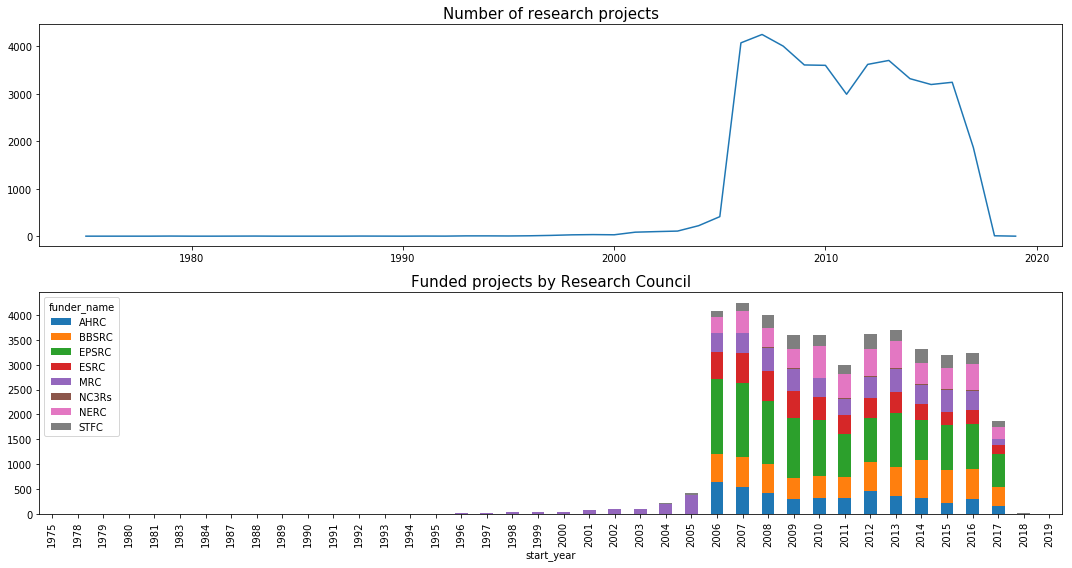

In [14]:
f, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,8))

# ax1
# Count the projects per year and sort them from older to newer ones. 
gtr_projects_df.start_year.value_counts().reindex(sorted(gtr_projects_df.start_year.value_counts().index)).plot(ax=ax1)
ax1.set_title('Number of research projects', fontsize=15)

# ax2 
# Group by the data on 'start_year' and 'funder_name' and count the number of projects belonging to each of these groups.
gtr_projects_df.groupby(['start_year', 'funder_name']).count()['project_id'].unstack('funder_name').plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Funded projects by Research Council', fontsize=15)

plt.tight_layout()
plt.show()

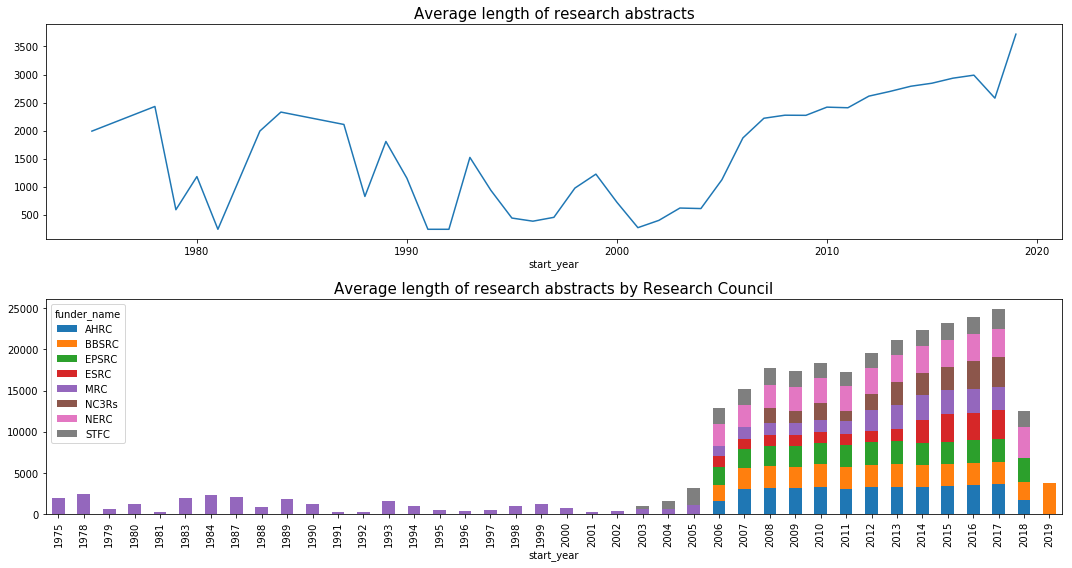

In [15]:
# Find the average length of the abstracts
gtr_projects_df['abstract_texts_length'] = gtr_projects_df.abstract_texts.apply(lambda doc: len(doc))

# Plot
f, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,8))

# ax1
# Group by the projects on the 'start_year' and average the length of their research abstracts.
gtr_projects_df.groupby('start_year').mean()['abstract_texts_length'].plot(ax=ax1)
ax1.set_title('Average length of research abstracts', fontsize=15)

# ax2 
# Group by the projects on the 'start_year' and 'funder_name' and average the length of the research abstracts for each group.
gtr_projects_df.groupby(['start_year', 'funder_name']).mean()['abstract_texts_length'].unstack('funder_name').plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Average length of research abstracts by Research Council', fontsize=15)

plt.tight_layout()
plt.show()

## Text preprocessing

### Goal

We will clean the abstract of every research project. 

### We will:
* Lowercase and tokenise the documents.
* Keep only tokens that have more than two characters.
* Filter out stop words, punctuation, numeric and non-English characters.
* Create n-grams.

### Some definitions

**Tokenisation:** It is a particular kind of document segmentation. Segmentation breaks up text into smaller chunks or segments, with more focused information content. Tokens are instances of a sequence of characters in some particular document that are grouped together as a useful semantic unit for processing.  
**Vocabulary:** A collection of the unique tokens found in a collection of documents.  
**One-hot-vectors:** A representation of tokens as binary vectors. The length of the vector is equal to the size of the vocabulary.  

<img src="../reports/figures/onehot.png" width="600">

### Other things that you could try:
* Change the regular expression used to tokenise the documents.
* Stem or lemmatise tokens based on their Part-of-Speech tag.

In [16]:
%%time
# Process the abstracts
gtr_projects_df['processed_documents'] = build_ngrams([flatten_lists(tokenize_document(document)) for document in list(gtr_projects_df.abstract_texts)])

CPU times: user 2min 4s, sys: 733 ms, total: 2min 5s
Wall time: 2min 5s


In [17]:
# Binary column showing if a document has any tokens left after preprocessing
gtr_projects_df['is_Doc'] = gtr_projects_df.processed_documents.apply(lambda doc: 1 if len(doc) != 0 else 0)

# Keep only rows with a processed abstract
gtr_projects_df = gtr_projects_df[gtr_projects_df.is_Doc == 1]

## Create word vectors

### Goal
Represent the words with vectors.

### We will:

Use [word2vec](https://radimrehurek.com/gensim/models/word2vec.html) to create a dense vector representation of tokens and project them to a low-dimensional vector space. This is done in a way that similar tokens will be closer on the vector space.

### Why not using something simpler?
Few disadvantages of one-hot-vectors:
* Very high dimensionality -> takes longer to train ML models.
* They do not learn based on their context, meaning that we cannot find relations between tokens.

<img src="../reports/figures/onehotencoding.png">

### What's word2vec?

Word2Vec is a shallow neural network which takes as input a large collection of sentences and produces a vector space of words, typically of several hundred dimensions where each word is assigned to corresponding vector in the space. Word vectors are positioned in the vector space in a way that those sharing similar context are located in close proximity to one another in the high dimensional vector space.  

<img src="../reports/figures/word2vec.png" width="800">

Word2Vec is a particularly computationally-efficient predictive model for learning word embeddings from raw text.

### Architecture

<img src="../reports/figures/w2v_architectures.png" width="800">

### Word2vec: Few important hyperparameters
* **`size`**: Dimensionality of the word vectors (length of the hidden layer).
* **`min_count`**: Ignores all words with total frequency lower than this.
* **`window`**: Maximum distance between the current and predicted word within a sentence.
* **`learning rate`**: The learning rate used in training.
* We can choose between the **`skip-gram`** and **`Continuous BOW`** implementation of the algorithm.
* We can choose **`Hierachical Softmax`** or **`Negative Sampling`** to train of the algorithm.


### Other methods you could use:
* One-hot-encodings
* Use a pre-trained word2vec model
* [TF-IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
* [GloVe](https://nlp.stanford.edu/projects/glove/)
* [fastText](https://fasttext.cc/)
* [ELMo](https://allennlp.org/elmo)

In [10]:
%%time
w2v = gensim.models.Word2Vec(list(gtr_projects_df.processed_documents), size=300, window=10, min_count=2, iter=20)

CPU times: user 10min 29s, sys: 2.02 s, total: 10min 31s
Wall time: 3min 37s


### Some examples of word2vec

We can query the trained word2vec with a token from its vocabulary and find the ones that are most similar to it. The float number of every "row" shows the cosine similarity between the query and the token on the left of the score.

In [11]:
w2v.wv.most_similar(['virtual_reality'])

[('virtual_environments', 0.7217650413513184),
 ('augmented_reality', 0.7136075496673584),
 ('listening', 0.7082576751708984),
 ('interactive', 0.7076694965362549),
 ('audio', 0.7025725841522217),
 ('audio_visual', 0.6982917189598083),
 ('interactively', 0.6910854578018188),
 ('immersive', 0.6900069117546082),
 ('animation', 0.6865305304527283),
 ('multimedia', 0.6838502883911133)]

In [12]:
w2v.wv.most_similar(['blockchain'])

[('high_street', 0.6506915092468262),
 ('users_needs', 0.6493762135505676),
 ('proof_of_concept_platform', 0.6485438346862793),
 ('digital_technology', 0.6407634615898132),
 ('mobile_technology', 0.6393041610717773),
 ('open_data', 0.6370972990989685),
 ('products_services', 0.6340044736862183),
 ('dlt', 0.6316045522689819),
 ('distributed_ledger', 0.6306949853897095),
 ('social_enterprises', 0.6304210424423218)]

In [13]:
w2v.wv.most_similar(['artificial_intelligence'])

[('computer_science', 0.8423026204109192),
 ('software_engineering', 0.8175503015518188),
 ('machine_learning', 0.8067601919174194),
 ('automated_reasoning', 0.7953647375106812),
 ('cryptography', 0.7897788286209106),
 ('computer_vision', 0.7887616157531738),
 ('programming_languages', 0.7865163683891296),
 ('multi_agent_systems', 0.7859323024749756),
 ('information_retrieval', 0.7835315465927124),
 ('natural_language', 0.7774830460548401)]

In [14]:
w2v.wv.most_similar(['machine_learning'])

[('data_mining', 0.8188040852546692),
 ('artificial_intelligence', 0.8067601919174194),
 ('computer_vision', 0.8034487962722778),
 ('algorithms', 0.7908055782318115),
 ('natural_language', 0.7851101160049438),
 ('software_engineering', 0.7691763043403625),
 ('inference', 0.7682020664215088),
 ('computer_based', 0.7681475877761841),
 ('signal_processing', 0.7599427700042725),
 ('support_vector', 0.7585594654083252)]

In [15]:
w2v.wv.most_similar(['big_data'])

[('analytics', 0.7418227195739746),
 ('cloud_computing', 0.7173663377761841),
 ('data_management', 0.7120195627212524),
 ('data_sources', 0.6979964971542358),
 ('data_sharing', 0.6879042387008667),
 ('digital_data', 0.6852988004684448),
 ('data_driven', 0.6836985349655151),
 ('data_integration', 0.6820377111434937),
 ('information_systems', 0.6784341931343079),
 ('visualisations', 0.672592282295227)]

In [71]:
w2v.wv.most_similar(['social_sciences'])

[('sociology', 0.8370311260223389),
 ('social_science', 0.8276510834693909),
 ('across_disciplines', 0.8175915479660034),
 ('humanities', 0.8157575726509094),
 ('range_disciplines', 0.8110742568969727),
 ('social_scientists', 0.7965325117111206),
 ('political_science', 0.7909771800041199),
 ('arts_humanities', 0.7802472114562988),
 ('theoretical_methodological', 0.7791591882705688),
 ('different_disciplines', 0.7739894390106201)]

In [73]:
w2v.wv.most_similar(['particle_physics'])

[('large_hadron', 0.8547588586807251),
 ('standard_model', 0.8311872482299805),
 ('collider_lhc', 0.8310647010803223),
 ('lhc', 0.8204831480979919),
 ('higgs_boson', 0.8190767765045166),
 ('collider', 0.8184897899627686),
 ('higgs', 0.8114563226699829),
 ('hadron_collider', 0.8040148019790649),
 ('boson', 0.8033125996589661),
 ('cosmology', 0.7966117858886719)]

## Create document vectors

### Goal 
Create document vectors!

### We will:
Average the word vectors of a document to create document vectors. The words that are not in word2vec model's vocabulary are ignored.

### Other methods you could use:
* Averaged word vectors weighted by their TF-IDF.
* [doc2vec](https://radimrehurek.com/gensim/models/doc2vec.html)
* [sent2vec](https://rare-technologies.com/sent2vec-an-unsupervised-approach-towards-learning-sentence-embeddings/)

In [16]:
# Take a sample of the data to make the second part of the tutorial run faster
gtr_projects_df = gtr_projects_df.sample(8000)

# Average word vectors
doc_vecs = [document_vector(doc=processed_document, word2vec_model=w2v) for processed_document in list(gtr_projects_df.processed_documents)]

## Cluster vectorised documents 

### Goal
Reduce the dimensionality of the document vectors and cluster them.

### We will:
* Find the cosine distance of the document vector matrix.
* Reduce its dimensionality to 2D using [t-SNE](https://lvdmaaten.github.io/tsne/).
* Cluster the points of the 2D space using [Gaussian Mixtures](https://scikit-learn.org/stable/modules/mixture.html)

### t-SNE
t-SNE is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data in a low-dimensional space (usually 2D).  

In the high-dimensional space, t-SNE creates a probability distribution that dictates the relationships between various neighbouring points. Then, it tries to recreate a low dimensional space that follows that probability distribution as best as possible.

<img src="../reports/figures/tsne.png" width="800">

#### t-SNE: Few important hyperparameters
* **`n_components`**: Dimension of the embedded space.
* **`perplexity`:** The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. The choice is not extremely critical since t-SNE is quite insensitive to this parameter. The performance of t-SNE is fairly robust under different settings of the perplexity. 
* **`learning_rate`:** If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the cost function gets stuck in a bad local minimum increasing the learning rate may help.

### Gaussian Mixtures
A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters.

<img alt="Credit: KazukiAmakawa [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)]" src="../reports/figures/gaussian_mixture.gif" width="800">

#### GMM: Few important hyperparameters
* **`n_components`**: The number of mixture components.
* **`covariance_type`**: The type of covariance to use.

<img src="../reports/figures/covariance_types.png" width="800">

### Other methods we could use:
* PCA (for dimensionality reduction)
* k-Means (for clustering)

In [17]:
%%time
# Dimensionality reduction with t-SNE
ts = WrapTSNE()
tsne_space = ts.reduce_dimensions(doc_vecs, n_iter=1000)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.150s...
[t-SNE] Computed neighbors for 20000 samples in 5.281s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sa

In [75]:
# Clustering with GMM
# Instantiate the class using the 2D space from t-SNE
np.random.seed(42)
gmm_eval = GaussianMixtureEval(tsne_space)

best_gmm, bic = gmm_eval.fit_eval(max_components=40)
print('BEST GMM MODEL: {}'.format(best_gmm))

BEST GMM MODEL: GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=35, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)


In [19]:
# Predict token clusters based on best_gmm
token_labels = best_gmm.predict(tsne_space)

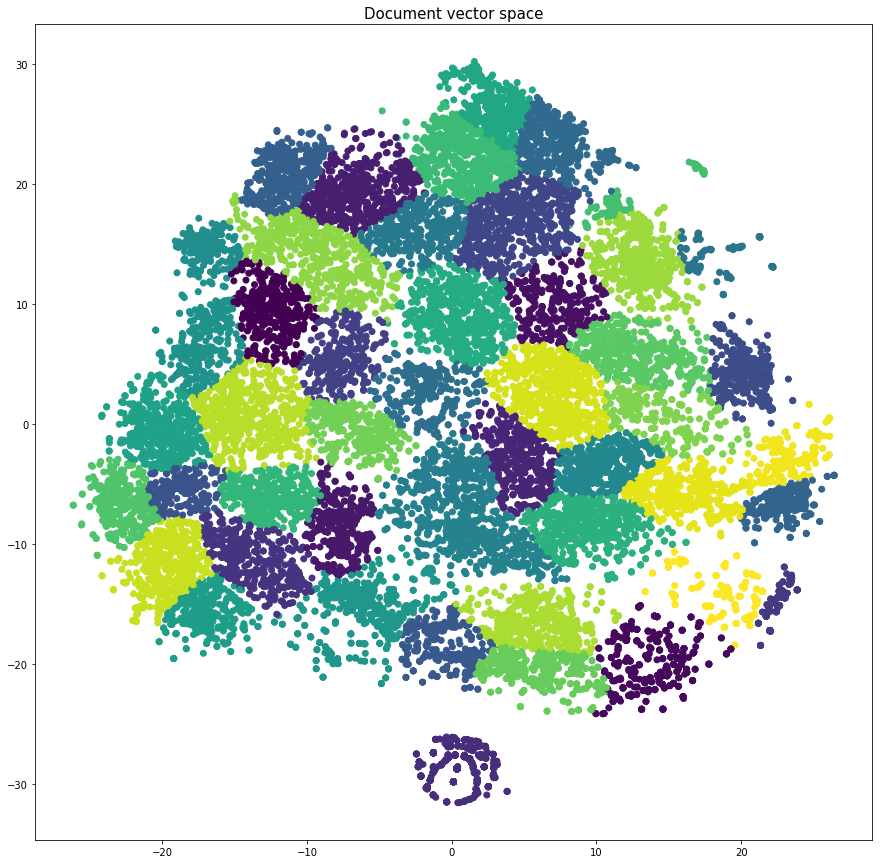

In [74]:
plt.figure(figsize=(15,15))
plt.scatter(tsne_space[:,0], tsne_space[:,1], c=token_labels)
plt.title('Document vector space', fontsize=15)
plt.show()

## Conclusions

In this tutorial, we've seen how to preprocess text data, find the vector representation of documents using word embeddings, reduced their dimensionality to 2D with t-SNE and cluster them with Gaussian Mixtures.

### Where can we go from here?
* Tryout the methods we mentioned at each part of the tutorial. Most of them will definitely improve the results!
* The methods we showcased can -in principle- be used with any text data. How would you use them in your work?

### Few things to consider
* **Scalability of the methods.** We decided to use less documents in t-SNE and GMMs in order to reduce the computing time.
* It's **difficult to evaluate** the results of unsupervised learning methods. 